In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
dataset = pd.read_excel('data/data.xlsx')
empty_data = dataset.dropna(how='all')
empty_data = empty_data.dropna(axis=1,how='all')
empty_data = empty_data.reset_index()
empty_data = empty_data.drop(columns=['L,p','index'])
dataset = empty_data


In [ ]:
#Set equal label type for sick people
for i, row in dataset.iterrows():
    label = row['label']
    if label == ' s':
        dataset.at[i,'label'] = 's'
    elif label == 'S':
        dataset.at[i,'label'] = 's'

In [ ]:
sick = dataset[(dataset['label']=='s')]
obese = dataset[(dataset['label']=='o')]
healthy = dataset[(dataset['label']=='k')]

In [ ]:
def percent_missing(df):
    percent_nan = 100* df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan

def draw_missing(dataset):
    ifg = plt.figure(figsize=(9,4),dpi=150)
    percent_nan = percent_missing(dataset)
    sns.barplot(x=percent_nan.index,y=percent_nan)
    plt.xticks(rotation=90)
    plt.ylim(0,100)

draw_missing(dataset)

In [ ]:
dataset.describe()

In [ ]:
#For rows where there is no age or weight, put random age generated from normal distribution with mean age and standard deviation of age
np.random.seed(300464)
for set in [sick, obese, healthy]:
    mean_age = set[['age']].mean()
    std_age = set[['age']].std()
    for i, row in set.iterrows():
        (weight, age) = row[['weight','age']]
        if  pd.isnull(age):
            new_age = np.random.normal(mean_age,std_age)
            set.at[i,'age'] = new_age
        if (age < 5) and (weight > 40):
            new_age = np.random.normal(mean_age,std_age)
            set.at[i,'age'] = new_age
  

In [ ]:
dataset = pd.concat((sick,healthy, obese))
dataset.describe()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [10]:
#####test

set = sick.copy()


set_to_predict = set[set['weight'].isnull()][['age', 'weight']].drop('weight', axis = 1)
set_train = set[set['weight'].notnull()][['age', 'weight']]

assert set.shape[0] == set_to_predict.shape[0] + set_train.shape[0]

X = set_train.drop('weight', axis = 1)
y = set_train['weight']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=515)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_real = scaler.transform(set_to_predict)

alphas = np.arange(0.001,10,0.01)
ridge_cv_model = RidgeCV(alphas=alphas,scoring='neg_root_mean_squared_error',cv=4,fit_intercept=True)
ridge_cv_model.fit(X_train,y_train)


train_predictions = ridge_cv_model.predict(X_train)

var = mean_squared_error(y_train,train_predictions)



for i, row in set.iterrows():
        (weight, age) = row[['weight','age']]
        if  pd.isnull(weight):
            prediction = ridge_cv_model.predict(scaler.transform(np.reshape(a = np.array(age),newshape = (1,-1))))
            E = prediction


            set.at[i,'weight'] = np.random.normal(E,var)

p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitte

# Weight

In [11]:
def predict_weight(set, loop=0, plots = False):
    set_to_predict = set[set['weight'].isnull()][['age', 'weight']].drop('weight', axis = 1)
    set_train = set[set['weight'].notnull()][['age', 'weight']]

    assert set.shape[0] == set_to_predict.shape[0] + set_train.shape[0]

    X = set_train.drop('weight', axis = 1)
    y = set_train['weight']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=515)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_real = scaler.transform(set_to_predict)

    alphas = np.arange(0.001,10,0.01)
    ridge_cv_model = RidgeCV(alphas=alphas,scoring='neg_root_mean_squared_error',cv=4)
    ridge_cv_model.fit(X_train,y_train)

    test_predictions = ridge_cv_model.predict(X_test)

    MAE = mean_absolute_error(y_test,test_predictions)
    MSE = mean_squared_error(y_test,test_predictions)
    RMSE = np.sqrt(MSE)

    print(f'MAE: {MAE}\nRMSE: {RMSE}')

    real_predictions = ridge_cv_model.predict(X_real)

    set_to_predict = np.squeeze(set_to_predict)

    if plots:
        sns.scatterplot(x=set_to_predict, y=real_predictions)
        sns.scatterplot(data=set_train, x='age', y='weight')
        if loop == 0:
            plt.title('Sick')
        elif loop == 1:
            plt.title('Obese')
        elif loop == 2:
            plt.title('Healthy')
        plt.show()

    for i, row in set.iterrows():
        (weight, age) = row[['weight','age']]
        if  pd.isnull(weight):
            new_weight = ridge_cv_model.predict(scaler.transform(np.reshape(a = np.array(age),newshape = (1,-1))))

            set.at[i,'weight'] = new_weight


MAE: 13.028519233008444
RMSE: 16.233277347136415


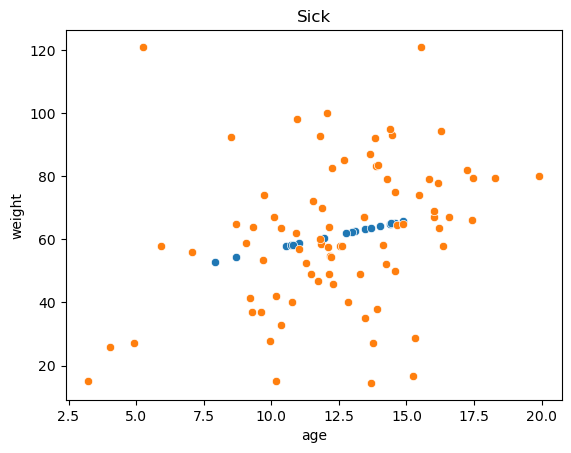

p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitte

MAE: 12.783036054044567
RMSE: 16.953857988712933


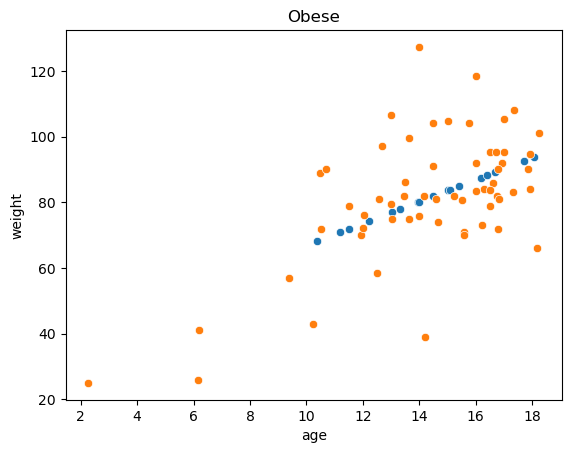

p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitte

MAE: 10.775008590477004
RMSE: 11.62326946981515


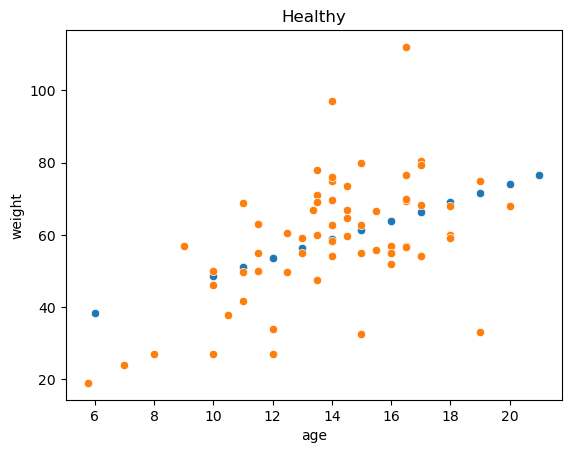

p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitte

In [12]:
loop = 0 
for set in [sick, obese, healthy]:
    predict_weight(set, loop, True)
    loop +=1

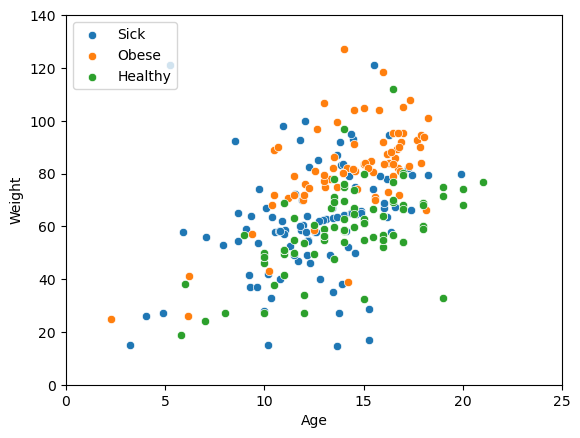

In [13]:

sns.scatterplot(data=sick, x = 'age', y='weight', label= 'Sick')
sns.scatterplot(data=obese, x = 'age', y='weight', label = 'Obese' )
sns.scatterplot(data=healthy, x = 'age', y='weight', label = 'Healthy')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.ylim((0,140))
plt.xlim((0,25))
plt.legend(loc=2)

In [14]:
dataset = pd.concat((sick,healthy, obese))
dataset.describe()

,age,weight,height,BMI,centyl,mean_for_age,SD_populacji,Z_score_BMI,wątroba powiększona,niejednorodnie podwyższona echogeniczność,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
count,275.000000,275.000000,208.000000,208.000000,127.000000,124.000000,123.000000,120.000000,275.000000,275.000000,...,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,13.615977,66.448200,1.606257,25.198620,74.196850,19.299194,2.701382,0.855838,0.040000,0.058182,...,0.364062,0.338989,0.355004,0.599156,0.221822,0.796567,0.721335,2.303855,2.299476,0.158831
std,3.113890,20.236100,0.202655,5.494137,33.330962,1.769823,0.465180,3.836220,0.196316,0.234514,...,0.306308,0.116597,0.083025,0.268206,0.100396,0.283803,0.269221,0.514975,0.777207,0.041243
min,2.270000,14.500000,0.670000,7.653061,3.000000,15.540000,1.280000,-10.881119,0.000000,0.000000,...,0.050000,0.100000,0.100000,0.100000,0.100000,0.210000,0.320000,1.310000,0.881664,0.069312
25%,11.816438,55.450000,1.540000,21.122453,50.000000,17.900000,2.520000,-0.433835,0.000000,0.000000,...,0.140000,0.250000,0.300000,0.375000,0.140000,0.610000,0.520000,2.010000,1.682791,0.128310
50%,14.000000,65.103509,1.657500,25.126759,97.000000,19.630000,2.710000,1.743748,0.000000,0.000000,...,0.190000,0.330000,0.360000,0.580000,0.190000,0.750000,0.680000,2.240000,2.170543,0.152644
75%,16.000000,80.000000,1.740000,28.648469,97.000000,20.790000,2.930000,2.603780,0.000000,0.000000,...,0.680000,0.405000,0.410000,0.855000,0.275000,0.930000,0.885000,2.580000,2.871609,0.184758
max,21.000000,127.300000,1.945000,40.429015,97.000000,21.650000,3.300000,16.722513,1.000000,1.000000,...,1.100000,0.990000,0.570000,1.160000,0.500000,2.570000,1.710000,3.990000,4.263959,0.282130


# Height

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNetCV

In [16]:
def predict_height(set, loop, plots = False):
    
    set_to_predict = set[set['height'].isnull()][['age', 'weight', 'height']].drop('height', axis = 1)
    set_train = set[set['height'].notnull()][['age', 'weight', 'height']]

    assert set.shape[0] == set_to_predict.shape[0] + set_train.shape[0]
    
    X = set_train.drop(columns= 'height', axis = 1)
    y = set_train['height']
    polyniomial_transformer = PolynomialFeatures(degree=2, include_bias=False)
    polyniomial_transformer = polyniomial_transformer.fit(X)
    polynomial_features = polyniomial_transformer.transform(X)
    set_to_predict_poly = polyniomial_transformer.transform(set_to_predict)

    X_train, X_test, y_train, y_test = train_test_split(polynomial_features, y, test_size=0.1, random_state=515)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_real = scaler.transform(set_to_predict_poly)

    elasticnet = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],tol=0.01)
    elasticnet.fit(X_train, y_train)   

    
    test_predictions = elasticnet.predict(X_test)

    MAE = mean_absolute_error(y_test,test_predictions)
    MSE = mean_squared_error(y_test,test_predictions)
    RMSE = np.sqrt(MSE)

    print(f'MAE: {MAE}\nRMSE: {RMSE}')

    real_predictions = elasticnet.predict(X_real)

    set_to_predict = np.squeeze(set_to_predict[['age']])

    if plots:
        sns.scatterplot(x=set_to_predict, y=real_predictions)
        sns.scatterplot(data=set_train, x='age', y='height')
        if loop == 0:
            plt.title('Sick')
        elif loop == 1:
            plt.title('Obese')
        elif loop == 2:
            plt.title('Healthy')
        plt.show()

    for i, row in set.iterrows():
        if not(pd.notnull(row['height'])):
            row_data = np.expand_dims((row[['age', 'weight']].values), axis = 0 )
            
            row_data_poly = polyniomial_transformer.transform(row_data)
            new_height = elasticnet.predict(scaler.transform( row_data_poly))
            set.at[i,'height'] = new_height
    
    

MAE: 0.08151068803519815
RMSE: 0.11065111766310164


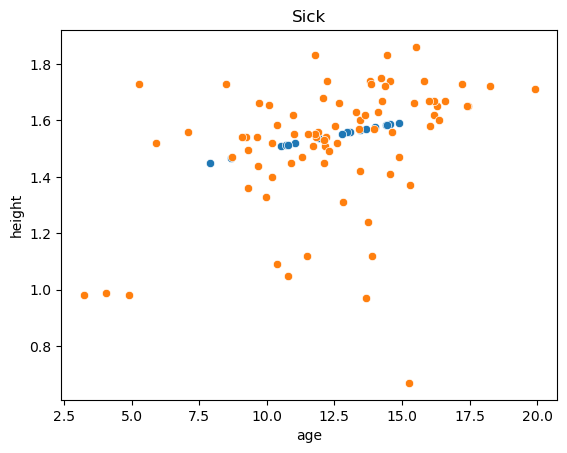

p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but Poly

MAE: 0.06741008953747654
RMSE: 0.07225008485784135


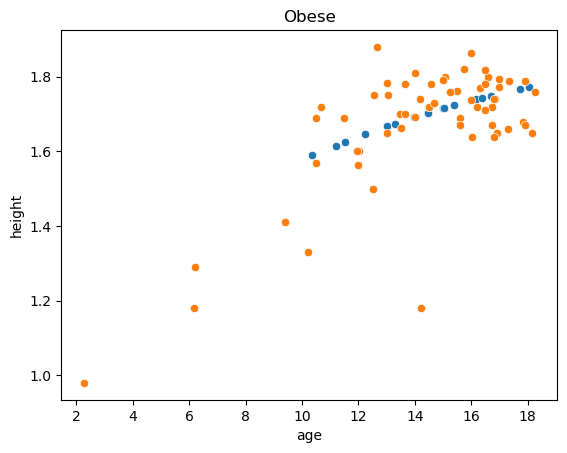

p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but Poly

MAE: 0.07401255022167498
RMSE: 0.07593653592232637


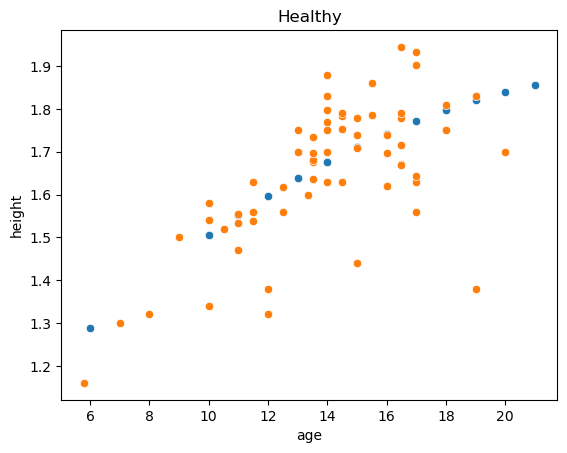

p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but Poly

In [17]:
loop = 0 
for set in [sick, obese, healthy]:
    predict_height(set, loop, True)
    loop +=1

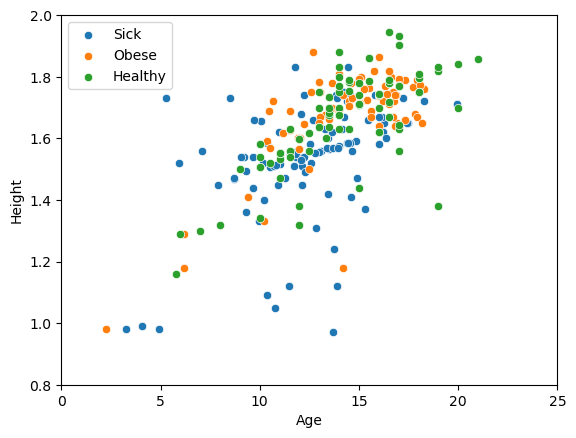

In [18]:

sns.scatterplot(data=sick, x = 'age', y='height', label= 'Sick')
sns.scatterplot(data=obese, x = 'age', y='height', label = 'Obese' )
sns.scatterplot(data=healthy, x = 'age', y='height', label = 'Healthy')
plt.xlabel('Age')
plt.ylabel('Height')
plt.ylim((0.8,2))
plt.xlim((0,25))
plt.legend(loc=2)

In [19]:
dataset = pd.concat((sick,healthy, obese))
dataset.describe()

,age,weight,height,BMI,centyl,mean_for_age,SD_populacji,Z_score_BMI,wątroba powiększona,niejednorodnie podwyższona echogeniczność,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
count,275.000000,275.000000,275.000000,208.000000,127.000000,124.000000,123.000000,120.000000,275.000000,275.000000,...,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,13.615977,66.448200,1.616496,25.198620,74.196850,19.299194,2.701382,0.855838,0.040000,0.058182,...,0.364062,0.338989,0.355004,0.599156,0.221822,0.796567,0.721335,2.303855,2.299476,0.158831
std,3.113890,20.236100,0.184666,5.494137,33.330962,1.769823,0.465180,3.836220,0.196316,0.234514,...,0.306308,0.116597,0.083025,0.268206,0.100396,0.283803,0.269221,0.514975,0.777207,0.041243
min,2.270000,14.500000,0.670000,7.653061,3.000000,15.540000,1.280000,-10.881119,0.000000,0.000000,...,0.050000,0.100000,0.100000,0.100000,0.100000,0.210000,0.320000,1.310000,0.881664,0.069312
25%,11.816438,55.450000,1.550000,21.122453,50.000000,17.900000,2.520000,-0.433835,0.000000,0.000000,...,0.140000,0.250000,0.300000,0.375000,0.140000,0.610000,0.520000,2.010000,1.682791,0.128310
50%,14.000000,65.103509,1.660000,25.126759,97.000000,19.630000,2.710000,1.743748,0.000000,0.000000,...,0.190000,0.330000,0.360000,0.580000,0.190000,0.750000,0.680000,2.240000,2.170543,0.152644
75%,16.000000,80.000000,1.740000,28.648469,97.000000,20.790000,2.930000,2.603780,0.000000,0.000000,...,0.680000,0.405000,0.410000,0.855000,0.275000,0.930000,0.885000,2.580000,2.871609,0.184758
max,21.000000,127.300000,1.945000,40.429015,97.000000,21.650000,3.300000,16.722513,1.000000,1.000000,...,1.100000,0.990000,0.570000,1.160000,0.500000,2.570000,1.710000,3.990000,4.263959,0.282130


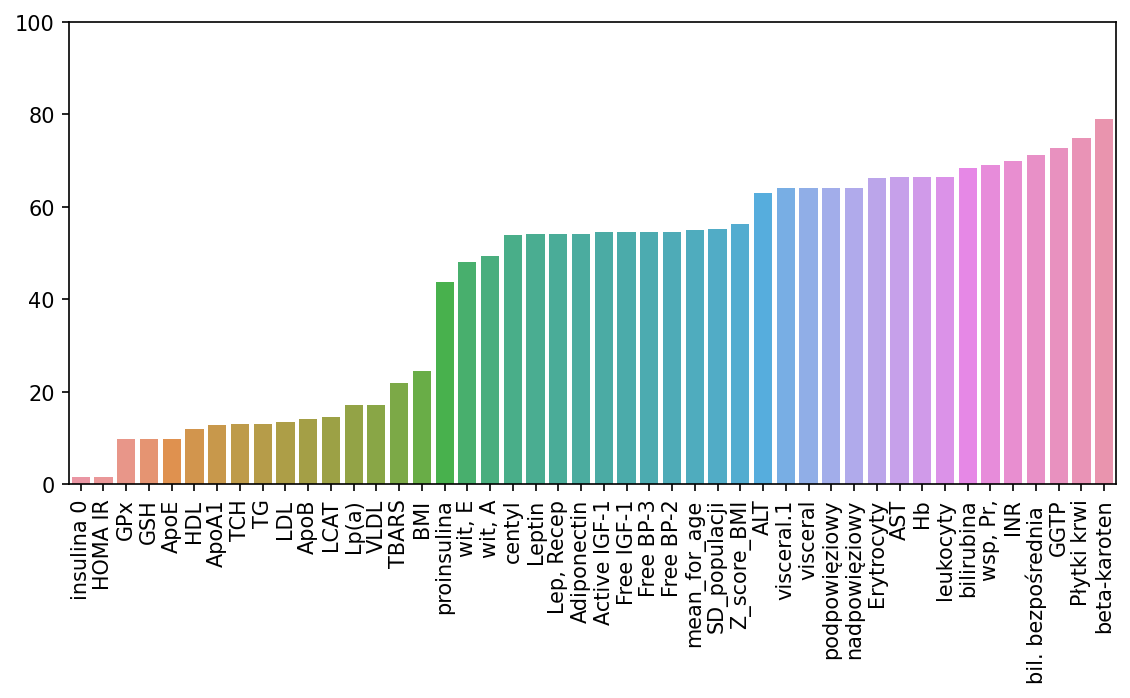

In [20]:
draw_missing(dataset)

In [22]:
for column in ['insulina 0','HOMA IR','mean_for_age', 'SD_populacji','Z_score_BMI', 'GPx','GSH', 'ApoE', 'HDL','ApoA1','TCH','TG','LDL', 'ApoB', 'LCAT', 'VLDL', 'Lp(a)', 'TBARS']:
    dataset[column] = dataset[column].transform(lambda val: val.fillna(val.mean()))

In [23]:
dataset.loc[dataset['BMI'].isnull(), ['BMI']] = dataset[dataset['BMI'].isnull()]['weight']/(dataset[dataset['BMI'].isnull()]['height']**2)


### Dealing with categorical columns

Change 'centyl' column


In [24]:
dataset[dataset['centyl'].notnull()]['centyl'] = dataset[dataset['centyl'].notnull()]['centyl'].apply(int)
for column in ['centyl']:
    dataset[column] = dataset[column].transform(lambda val: val.fillna(val.mean()))

C:\Users\Kubi\AppData\Local\Temp\ipykernel_28328\1321646763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dataset['centyl'].notnull()]['centyl'] = dataset[dataset['centyl'].notnull()]['centyl'].apply(int)


Change sex column to numerical

In [25]:
dataset.loc[dataset['sex'] != 'D', ['sex']] = 'C'
dataset['sex'] = pd.get_dummies(dataset['sex'],drop_first=True)

Change 'bilirubina' column

In [26]:
dataset.loc[dataset['bilirubina'] == '<1,0', ['bilirubina']] = 0.5
dataset.loc[dataset['bilirubina'] == '< 1,0', ['bilirubina']] = 0.5
dataset.loc[dataset['bilirubina'].isnull(), ['bilirubina']] = 1
dataset['bilirubina'] = dataset['bilirubina'].apply(float)

dataset.loc[dataset['bil. bezpośrednia '] == '<1,0', ['bil. bezpośrednia ']] = 0.5
dataset.loc[dataset['bil. bezpośrednia '] == '< 1,0', ['bil. bezpośrednia ']] = 0.5
dataset.loc[dataset['bil. bezpośrednia '].isnull(), ['bil. bezpośrednia ']] = 1
dataset['bil. bezpośrednia '] = dataset['bil. bezpośrednia '].apply(float)

Change 'visceral' column

In [27]:
dataset['visceral'] = dataset['visceral'].transform(lambda val: val.fillna(val.mean()))

### Continue to fill missing values

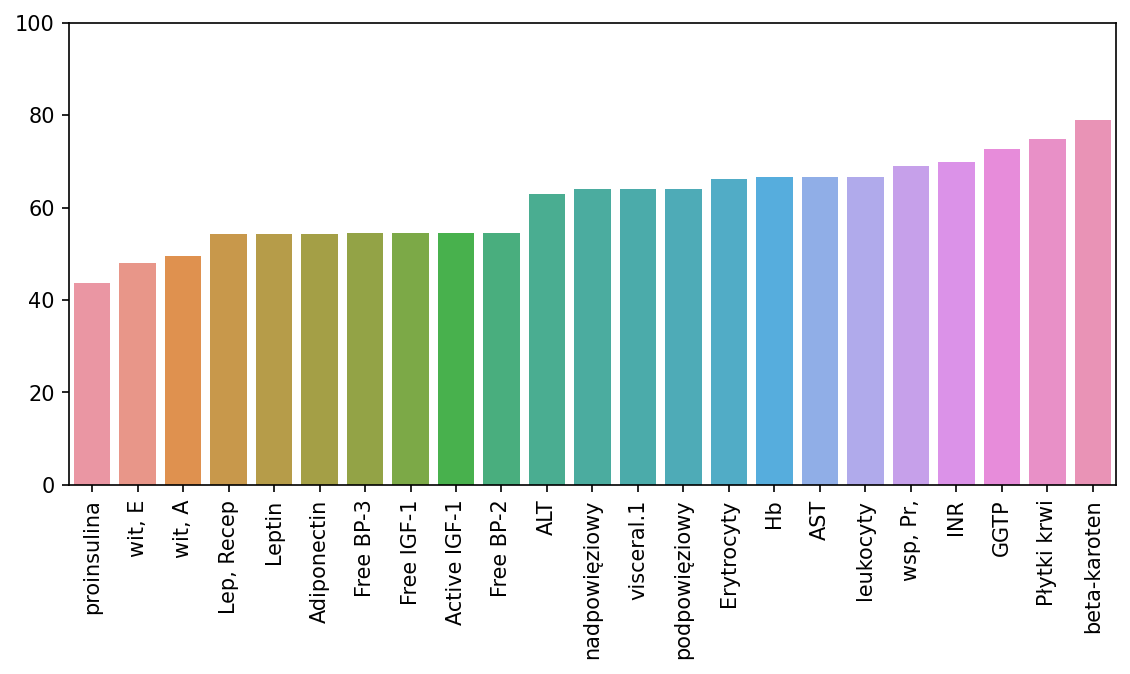

In [28]:
draw_missing(dataset)

In [30]:
for column in ['beta-karoten',  'GGTP','Erytrocyty', 'AST','leukocyty', 'visceral.1','nadpowięziowy', 'podpowięziowy','ALT','wit, A', 'wit, E','proinsulina','Adiponectin','Leptin','Lep, Recep','Active IGF-1','Free IGF-1','Free BP-2','Free BP-3',]:
    dataset[column] = dataset[column].transform(lambda val: val.fillna(val.median()))

In [31]:
dataset.loc[(dataset['Erytrocyty'].isnull()) & (dataset['sex'] == False), 'Erytrocyty'] = 5
dataset.loc[(dataset['Erytrocyty'].isnull()) & (dataset['sex'] == True), 'Erytrocyty'] = 4

dataset.loc[(dataset['leukocyty'].isnull()) & (dataset['age'] < 6), 'leukocyty'] = 10
dataset.loc[(dataset['leukocyty'].isnull()) & (dataset['age'] < 18), 'leukocyty'] = 9
dataset.loc[(dataset['leukocyty'].isnull()), 'leukocyty'] = 7

dataset.loc[(dataset['Hb'].isnull()) & (dataset['sex'] == False), 'Hb'] = 15.5
dataset.loc[(dataset['Hb'].isnull()) & (dataset['sex'] == True), 'Hb'] = 14

dataset.loc[(dataset['Płytki krwi'].isnull()), 'Płytki krwi'] = 250
dataset.loc[(dataset['INR'].isnull()), 'INR'] = 1
dataset.loc[(dataset['wsp, Pr,'].isnull()), 'wsp, Pr,'] = 1



DATA IS COMPLETE NOW

In [32]:
dataset

,age,label,sex,weight,height,BMI,centyl,mean_for_age,SD_populacji,Z_score_BMI,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
0,16.282192,s,False,94.500000,1.650000,34.710744,97.00000,20.790000,2.500000,5.568298,...,0.567,0.112,0.196,0.158,0.151,0.436,1.547,1.68,0.881664,0.226844
1,13.432877,s,True,67.000000,1.600000,26.171875,96.00000,19.100000,2.750000,2.571591,...,0.390,0.250,0.280,0.150,0.130,0.670,1.310,2.52,3.193548,0.161374
2,11.879452,s,True,70.000000,1.560000,28.763971,74.19685,19.299194,2.701382,0.855838,...,0.950,0.330,0.510,0.130,0.210,0.600,1.710,1.85,2.092457,0.222764
3,10.904110,s,False,62.000000,1.450000,29.488704,74.19685,19.299194,2.701382,0.855838,...,0.270,0.240,0.470,0.410,0.250,0.430,1.610,2.23,1.568849,0.243139
4,18.265753,s,True,79.500000,1.720000,26.872634,97.00000,21.640000,2.690000,1.945217,...,0.910,0.190,0.300,0.250,0.470,1.050,1.410,2.98,1.467967,0.170871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,14.484484,o,True,81.851380,1.703677,28.200139,74.19685,19.299194,2.701382,0.855838,...,0.160,0.190,0.390,0.830,0.140,0.630,0.610,2.25,3.940678,0.131623
271,2.270000,o,False,25.000000,0.980000,26.030820,74.19685,19.299194,2.701382,0.855838,...,0.320,0.340,0.410,0.860,0.160,0.810,0.520,2.03,3.004695,0.107903
272,16.800000,o,True,90.000000,1.740000,29.900000,97.00000,21.100000,2.520000,3.491308,...,0.150,0.250,0.280,0.890,0.410,0.840,0.700,1.68,1.944444,0.154589
273,18.163417,o,True,66.000000,1.650000,24.240000,74.19685,19.299194,2.701382,0.855838,...,0.180,0.210,0.300,0.970,0.280,1.200,0.630,1.48,2.862745,0.155773


In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 0 to 274
Columns: 107 entries, age to DGLA/LA
dtypes: bool(1), float64(101), int64(4), object(1)
memory usage: 230.2+ KB


In [34]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
dataset['sex'] = lb.fit_transform(dataset['sex'])
def binarize(x, bin = False):
    if bin:
        if x == 's':
            return 0
        else:
            return 1
    else:
        if x == 's':
            return 0
        elif x == 'k':
            return 1
        elif x == 'o':
            return 2
        


In [35]:
dataset_cat = dataset.copy()
dataset_bin = dataset.copy()
# dataset_bin['label'] = 
dataset_bin['label'] = dataset_bin['label'].apply(binarize, bin=True)
dataset_cat['label'] = dataset_cat['label'].apply(binarize)


In [36]:
dataset_cat.to_csv('data/data_processed_cat.csv', index= False)
dataset_bin.to_csv('data/data_processed_bin.csv', index= False)

In [37]:
data_check = pd.read_csv('data/data_processed_bin.csv')
data_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Columns: 107 entries, age to DGLA/LA
dtypes: float64(101), int64(6)
memory usage: 230.0 KB


In [38]:
data_check.head()

,age,label,sex,weight,height,BMI,centyl,mean_for_age,SD_populacji,Z_score_BMI,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
0,16.282192,0,0,94.5,1.65,34.710744,97.00000,20.790000,2.500000,5.568298,...,0.567,0.112,0.196,0.158,0.151,0.436,1.547,1.68,0.881664,0.226844
1,13.432877,0,1,67.0,1.60,26.171875,96.00000,19.100000,2.750000,2.571591,...,0.390,0.250,0.280,0.150,0.130,0.670,1.310,2.52,3.193548,0.161374
2,11.879452,0,1,70.0,1.56,28.763971,74.19685,19.299194,2.701382,0.855838,...,0.950,0.330,0.510,0.130,0.210,0.600,1.710,1.85,2.092457,0.222764
3,10.904110,0,0,62.0,1.45,29.488704,74.19685,19.299194,2.701382,0.855838,...,0.270,0.240,0.470,0.410,0.250,0.430,1.610,2.23,1.568849,0.243139
4,18.265753,0,1,79.5,1.72,26.872634,97.00000,21.640000,2.690000,1.945217,...,0.910,0.190,0.300,0.250,0.470,1.050,1.410,2.98,1.467967,0.170871
